In [16]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tahar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tahar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tahar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
df = pd.read_csv('IMDB Dataset.csv')  
df = df.sample(1000, random_state=42).reset_index(drop=True)

In [18]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Suppression des URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Suppression des caractères spéciaux et chiffres
    text = text.lower()  # Conversion en minuscules
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]        
    return text

In [19]:
df['cleaned_review'] = df['review'].apply(clean_text)

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

# Tokenisation avec BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)
label_mapping = {'negative': 0, 'positive': 1}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

In [21]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
class MovieReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])  # Convertir les étiquettes en tenseur
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MovieReviewsDataset(train_encodings, y_train)
test_dataset = MovieReviewsDataset(test_encodings, y_test)

In [22]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir='./results',          # Répertoire où les résultats seront sauvegardés
    num_train_epochs=3,              # Nombre d'époques d'entraînement
    per_device_train_batch_size=16,  # Taille du batch pour l'entraînement
    per_device_eval_batch_size=64,   # Taille du batch pour l'évaluation
    warmup_steps=500,                # Nombre d'étapes de réchauffement
    weight_decay=0.01,               # Taux de décroissance du poids
    logging_dir='./logs',            # Répertoire pour les logs
    logging_steps=10,
)

# Entraînement du modèle avec le Trainer de HuggingFace
trainer = Trainer(
    model=model,                         # Le modèle pré-entrainé
    args=training_args,                  # Paramètres d'entraînement
    train_dataset=train_dataset,         # Jeu de données d'entraînement
    eval_dataset=test_dataset,           # Jeu de données de test
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)}
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\tahar\AppData\Local\Temp\ipykernel_27304\2992333691.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,0.761900
20,0.730500
30,0.671400
40,0.691800
50,0.683600
60,0.672100
70,0.661800
80,0.602900
90,0.653400
100,0.622900


TrainOutput(global_step=150, training_loss=0.6020281664530436, metrics={'train_runtime': 5757.4096, 'train_samples_per_second': 0.417, 'train_steps_per_second': 0.026, 'total_flos': 631466532864000.0, 'train_loss': 0.6020281664530436, 'epoch': 3.0})

C:\Users\tahar\AppData\Local\Temp\ipykernel_27304\2992333691.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Results: {'eval_loss': 0.42433974146842957, 'eval_accuracy': 0.835, 'eval_runtime': 85.2053, 'eval_samples_per_second': 2.347, 'eval_steps_per_second': 0.047, 'epoch': 3.0}


C:\Users\tahar\AppData\Local\Temp\ipykernel_27304\2992333691.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

           0       0.95      0.75      0.84       114
           1       0.74      0.94      0.83        86

    accuracy                           0.83       200
   macro avg       0.84      0.85      0.83       200
weighted avg       0.86      0.83      0.84       200



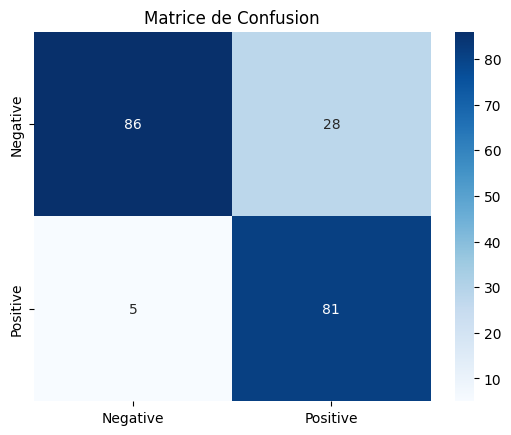

Exemple de critiques mal classées :
Critique : Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attitude of Emma. She is funny without being excessively silly, yet elegant. She puts on a very convincing British accent (not being British myself, maybe I'm not the best judge, but she fooled me...she was also excellent in "Sliding Doors"...I sometimes forget she's American ~!). <br /><br />Also brilliant are Jeremy Northam and Sophie Thompson and Phyllida Law (Emma Thompson's sister and mother) as the Bates women. They nearly steal the show...and Ms. Law doesn't even have any lines!<br /><br />Highly recommended.
Sentiment réel : 0, Sentiment prédit : 1

Critique : I was very disappointed with this series. It had lots of cool graphics and that's about it. The level of detail it went into was minimal, and I always got the feeling the audience was being patronized -- there was a lot of what seemed to me as "This is extremely cool

In [23]:
results = trainer.evaluate()
print(f"Evaluation Results: {results}")
# Prédiction sur les données de test
predictions = trainer.predict(test_dataset)
# Calcul des métriques de classification
y_pred = predictions.predictions.argmax(axis=-1)
print(classification_report(y_test, y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Matrice de Confusion")
plt.show()
# Exemple d'erreurs de classification
misclassified_indices = np.where(y_test != y_pred)[0]
print("Exemple de critiques mal classées :")
for i in range(5):
    index = misclassified_indices[i]
    print(f"Critique : {df.iloc[index]['review']}")
    print(f"Sentiment réel : {y_test.iloc[index]}, Sentiment prédit : {y_pred[index]}\n")

In [26]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')
print("Modèle enregistrés dans './saved_model'")

Modèle enregistrés dans './saved_model'
